# Aquanet Light Sensor

In [106]:
import os
from matplotlib import pyplot as plt
import pandas as pd

from loguru import logger

logger.enable("nviro_fetch")

In [7]:
os.getcwd()

'/home/wspamer/dev/python/nvirosense/notebooks'

## Setup

In [26]:
from src.devices import check_and_load_devices
from src.env import env_global
from src.readings import (
    export_readings,
    import_readings,
    calculate_time_difference,
)

start_date = env_global("start_date")
end_date = env_global("end_date")
path_data = env_global("path_data")
path_readings = f"{path_data}/readings"
devices = check_and_load_devices()

## 1) Import

In [133]:
device_name = "Aquanet Light Sensor"
device = [device for device in devices if device["device_name"] == device_name][0]
df = import_readings(
    device_name=device["device_name"].replace(" ", "_").lower()
)

2025-06-13 17:28:54.650 | INFO     | src.files:find_file:84 - Found file: aquanet_light_sensor_2025-06-11.csv for device: aquanet_light_sensor
2025-06-13 17:28:54.651 | INFO     | src.readings:import_readings:64 - Importing readings from file: aquanet_light_sensor_2025-06-11.csv
2025-06-13 17:28:54.660 | INFO     | src.readings:import_readings:74 - Readings imported successfully from data/readings/raw/aquanet_light_sensor_2025-06-11.csv


## 2) Common Interval


In [73]:
def round_interval(dt, time_diff, interval=15):
    if abs(time_diff - interval) < 3:
        return dt.floor(f"{str(interval)} min")
    else:
        return dt

In [ ]:
df["time_diff"] = calculate_time_difference(df["dt"])
df = df[df["time_diff"] >= 5]  # Filter out readings with time difference < 5 minutes
# df = df[df["time_diff"] >= 5]  # Filter out readings with time difference < 5 minutes

In [99]:
s_diff = df["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

time_diff
10      893
15      856
20       50
30       48
14       32
16       27
390       2
1200      1
31        1
750       1
420       1
Name: count, dtype: int64

In [ ]:
# df["dt"] = df.apply(
#     lambda x: round_interval(x["dt"], x["time_diff"]), axis=1
# )

### 2.1) Identify Interval Change


In [100]:
date_change = df[df["time_diff"] == 15]['dt'].max()

In [93]:
df[df["time_diff"] == 10]["dt"].min()

Timestamp('2025-06-03 13:37:00+0000', tz='UTC')

## 3) Round to common interval

### 3.1) Interval: 15


In [144]:
df1 = df[df["dt"] <= date_change]

s_diff = df1["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

time_diff
15      856
30       48
14       32
16       27
1200      1
31        1
750       1
420       1
Name: count, dtype: int64

In [145]:
# Snap all datetimes to the nearest lower 15-minute mark from the hour


freq = "15min"
df1["dt"] = df1["dt"].dt.floor(freq)
# Remove duplicates that may result from flooring
df1 = df1.drop_duplicates(subset="dt", keep="first")

# Optionally, reindex to ensure every 10-minute interval is present
full_range = pd.date_range(df1["dt"].min(), df1["dt"].max(), freq=freq)
df1 = df1.set_index("dt").reindex(full_range)
df1["dt"] = df1.index
# Optionally, forward-fill or interpolate missing values
# df1 = df1.ffill()

/tmp/ipykernel_110804/3130095819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["dt"] = df1["dt"].dt.floor(freq)


In [146]:
df1["dt_diff"] = calculate_time_difference(df1["dt"])
s_diff = df1["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

dt_diff
15    1170
Name: count, dtype: int64

### 3.2) Interval: 10


In [147]:
df2 = df[df["dt"] > date_change]
s_diff = df2["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

time_diff
10     893
20      50
390      2
Name: count, dtype: int64

In [148]:
freq = "10min"
df2["dt"] = df2["dt"].dt.floor(freq)
# Remove duplicates that may result from flooring
df2 = df2.drop_duplicates(subset="dt", keep="first")

# Optionally, reindex to ensure every 10-minute interval is present
full_range = pd.date_range(df2["dt"].min(), df2["dt"].max(), freq=freq)
df2 = df2.set_index("dt").reindex(full_range)
df2["dt"] = df2.index
# Optionally, forward-fill or interpolate missing values
# df2 = df2.ffill()

/tmp/ipykernel_110804/612626256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["dt"] = df2["dt"].dt.floor(freq)


In [150]:
df2["dt_diff"] = calculate_time_difference(df2["dt"])
s_diff = df2["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

dt_diff
10    1072
Name: count, dtype: int64

### 3.3) Combine


In [151]:
df_new = pd.concat([df1, df2])
df_new = df_new.sort_values(by="dt")

In [143]:
df_new["time_diff"] = calculate_time_difference(df_new["dt"])

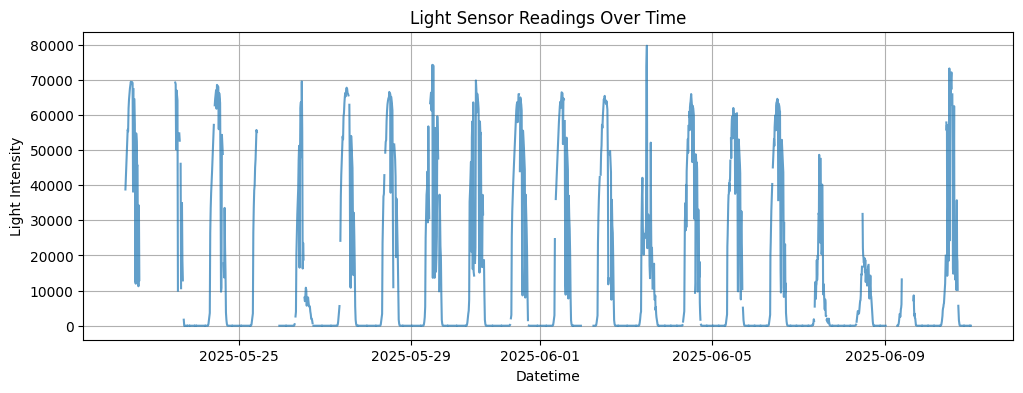

In [153]:
plt.figure(figsize=(12, 4))
plt.plot(df_new.LIGHT, alpha=0.7)
plt.title("Light Sensor Readings Over Time")
plt.xlabel("Datetime")
plt.ylabel("Light Intensity")
plt.grid(True)
plt.show()

### 3.4) Exploration

In [ ]:
explore_interval = 43 
df["day"] = df["dt"].dt.date

explore_day = df[df["time_diff2"] == explore_interval]["day"].to_list()[0]

In [63]:
df_view = df[df["day"] == explore_day].copy()

In [ ]:
df["dt_10"] = df.apply(
    lambda row: row["dt"].floor(f"{str(interval_common)} min"), axis=1
)

df["dt_diff"] = df.apply(
    lambda row: (row["dt"] - row["dt_10"]).total_seconds() / 60, axis=1
)

## 4) Check for any issues

In [152]:
s_diff = df_new["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head()

dt_diff
15    1170
10    1072
Name: count, dtype: int64

## 5) Set new date as default

In [ ]:
df_final = df.copy(deep=True)
df_final.reset_index(inplace=True, drop=True)
df_final["datetime"] = df_final["dt_10"]
df_final.drop(columns=["dt" ,"time_diff", "dt_10", "dt_diff"], inplace=True)

## 6) Export

In [ ]:
path_cleaned = os.path.join(path_readings, "cleaned")
end_date = df_final["datetime"].max().strftime("%Y-%m-%d %H:%M:%S")
export_readings(path_cleaned, df_final, device, end_date)